<a href="https://colab.research.google.com/github/ravi-gopalan/quadcopter/blob/colab_version/quadcopter_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

In [1]:
!ls -la


total 16
drwxr-xr-x 1 root root 4096 May 24 16:08 .
drwxr-xr-x 1 root root 4096 May 29 00:05 ..
drwxr-xr-x 1 root root 4096 May 24 16:08 .config
drwxr-xr-x 1 root root 4096 May 24 16:08 sample_data


In [0]:
!mkdir quadcopter

In [35]:
#!cp -v /task.py /content/quadcopter/
#!cp -v /physics_sim.py /content/quadcopter/
!cp -v /agent.py /content/quadcopter/
#!cp -v /policy_search.py /content/quadcopter/
!cp -v /takeoff.py /content/quadcopter/



'/agent.py' -> '/content/quadcopter/agent.py'
'/takeoff.py' -> '/content/quadcopter/takeoff.py'


In [9]:
cd quadcopter

/content/quadcopter


In [0]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import csv
import numpy as np
import sys


In [0]:
class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]


In [10]:
%load_ext autoreload
%autoreload 2

from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 500.                                     # time limit of the episode
init_pose = np.array([0., 0., 1., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting default init pose


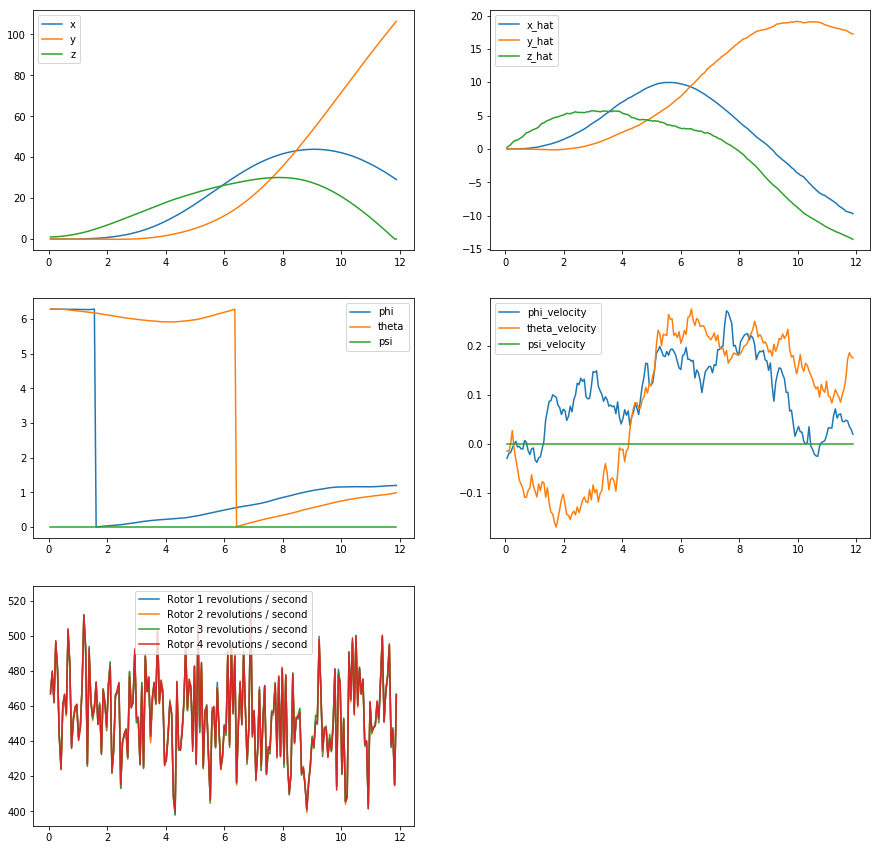

In [11]:
%matplotlib inline

fig_1 = plt.figure(figsize=(15,15))
gs_1 = gridspec.GridSpec(3, 2)

ax1 = plt.subplot(gs_1[0, 0])
ax1 = plt.plot(results['time'], results['x'], label='x')
ax1 = plt.plot(results['time'], results['y'], label='y')
ax1 = plt.plot(results['time'], results['z'], label='z')
plt.legend()



ax2 = plt.subplot(gs_1[0, 1])
ax2 = plt.plot(results['time'], results['x_velocity'], label='x_hat')
ax2 = plt.plot(results['time'], results['y_velocity'], label='y_hat')
ax2 = plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()

ax3 = plt.subplot(gs_1[1, 0])
ax3 = plt.plot(results['time'], results['phi'], label='phi')
ax3 = plt.plot(results['time'], results['theta'], label='theta')
ax3 = plt.plot(results['time'], results['psi'], label='psi')
plt.legend()


ax4 = plt.subplot(gs_1[1, 1])
ax4 = plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
ax4 = plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
ax4 = plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()

ax5 = plt.subplot(gs_1[2, 0])
ax5 = plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
ax5 = plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
ax5 = plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
ax5 = plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')


plt.legend()
_ = plt.ylim()

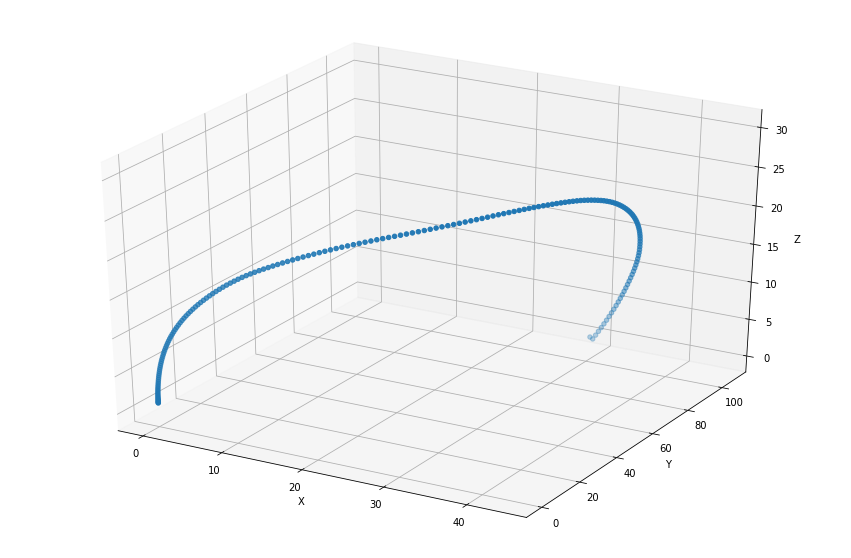

In [12]:
from mpl_toolkits.mplot3d import Axes3D
# Make sure to change from notebook to inline after your tests
%matplotlib inline


fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(results['x'], results['y'], results['z'])
plt.show()

In [13]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[ 29.0503018  106.37393379   0.           1.20124055   0.99317102
   0.        ]
[ -9.73429297  17.21972856 -13.56373109]
[0.01919822 0.17512804 0.        ]


In [14]:
pwd

'/content/quadcopter'

In [15]:
from policy_search import PolicySearch_Agent
from task import Task

num_episodes = 500
target_pos = np.array([0., 0., 200.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task)
#agent = PolicySearch_Agent(task)

reward_labels = ['episode', 'reward']
reward_results = {x : [] for x in reward_labels}

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    score = 0
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
#        agent.step(action, reward, next_state, done)

        state = next_state
#        score += reward
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
#    reward_results['episode'].append(i_episode)
#    reward_results['reward'].append(score)
    sys.stdout.flush()

Episode =  500, score = -10.626 (best =  -3.134), noise_scale = 3.2

In [36]:
from agent import DDPG
from takeoff import Task

num_episodes = 500
target_pos = np.array([10., 10., 300.])
task = Task(target_pos=target_pos, init_pose=init_pose)
agent = DDPG(task)

worst_score = 100000
best_score = -100000
reward_log = 'reward.txt'

reward_labels = ['episode', 'reward']
reward_results = {x : [] for x in reward_labels}

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    score = 0
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done)


        state = next_state
        score += reward
        best_score = max(best_score, score)
        worst_score = min(worst_score, score)
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), (worst = {:7.3f})".format(
                i_episode, score, best_score, worst_score), end="")  # [debug]
            break
    reward_results['episode'].append(i_episode)
    reward_results['reward'].append(score)
    sys.stdout.flush()


Episode =  500, score = 656.225 (best = 748.348), (worst = -136.537)

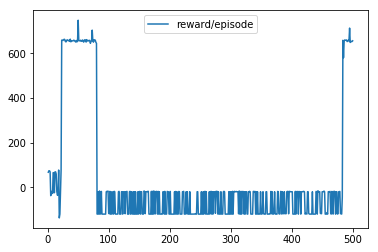

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(reward_results['episode'], reward_results['reward'], label='reward/episode')
plt.legend()
_ = plt.ylim()

In [38]:
np.array(reward_results['reward'][-10:]).mean()

660.242116758316

In [48]:
%load_ext autoreload
%autoreload 2

import csv
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 10000.                                     # time limit of the episode
init_pose = np.array([0., 0., 1., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
state = agent.reset_episode()
total_reward = 0
while True:
    rotor_speeds = agent.act(state)
    next_state, reward, done = task.step(rotor_speeds)
    to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
    for ii in range(len(labels)):
        results[labels[ii]].append(to_write[ii])
    total_reward += reward
    state = next_state
    if done:
        print("Total episode reward : {}".format(total_reward))
        total_reward = 0
        break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting default init pose
Total episode reward : -38718.01462111159


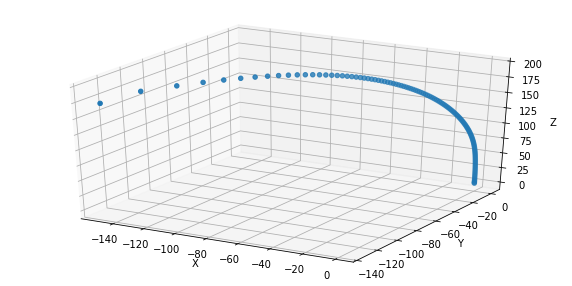

In [49]:
%matplotlib inline



fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(results['x'], results['y'], results['z'])


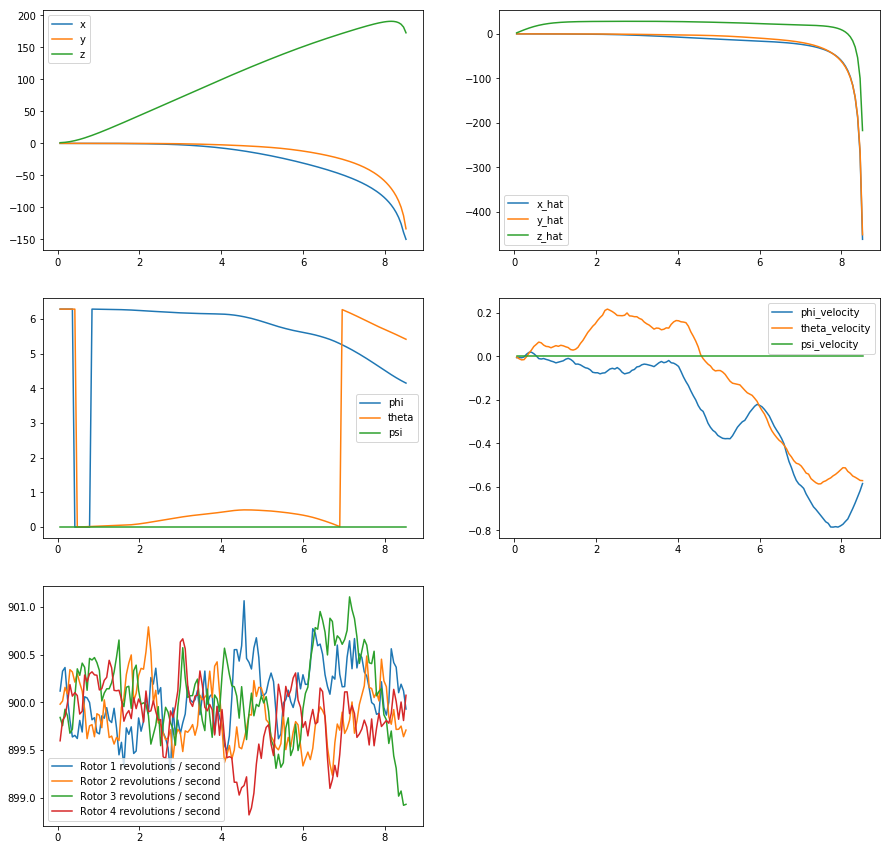

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

fig_2 = plt.figure(figsize=(15,15))
gs_2 = gridspec.GridSpec(3, 2)

ax1_2 = plt.subplot(gs_2[0, 0])
ax1_2 = plt.plot(results['time'], results['x'], label='x')
ax1_2 = plt.plot(results['time'], results['y'], label='y')
ax1_2 = plt.plot(results['time'], results['z'], label='z')
plt.legend()



ax2_2 = plt.subplot(gs_2[0, 1])
ax2_2 = plt.plot(results['time'], results['x_velocity'], label='x_hat')
ax2_2 = plt.plot(results['time'], results['y_velocity'], label='y_hat')
ax2_2 = plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()

ax3_2 = plt.subplot(gs_2[1, 0])
ax3_2 = plt.plot(results['time'], results['phi'], label='phi')
ax3_2 = plt.plot(results['time'], results['theta'], label='theta')
ax3_2 = plt.plot(results['time'], results['psi'], label='psi')
plt.legend()


ax4_2 = plt.subplot(gs_2[1, 1])
ax4_2 = plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
ax4_2 = plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
ax4_2 = plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()

ax5_2 = plt.subplot(gs_2[2, 0])
ax5_2 = plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
ax5_2 = plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
ax5_2 = plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
ax5_2 = plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')


plt.legend()
_ = plt.ylim()